<h1 style="text-align: center;">Assessment 2 Part A: PRML Project (Stage 2/3)</h1>
<h2 style="text-align: center;">Pattern Recognition and Machine Learning</h2> 
<h3 style="text-align: center;">By Ruhan Shafi | u3284342</h3>

PLEASE DO NOT CLICK "Run All" if there is a folder called "HAM10000_images", as it will cause errors, ensure that all files apart from this notebook/`README.md` are removed prior to running the download commands

## Importing Libraries

In [1]:
import pandas as pd
import tensorflow as tf
import os
import shutil
import zipfile
import glob
from sklearn.model_selection import train_test_split
import cv2
import numpy as np
from sklearn.preprocessing import LabelEncoder

2025-09-25 23:06:33.922931: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-09-25 23:06:34.315891: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-09-25 23:06:36.197725: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.


## Downloading the Dataset via Kaggle CLI
Please ensure that your Kaggle CLI environment is properly configurated prior to running this command. Please check Kaggle API documentation to find out to configure the Kaggle CLI for your enviroment. Once it has been properly configured, uncomment the second line and run this command. (This has been commented so prevent accidental downloads as this takes up allocated API useage and to save on time and storage)

In [9]:
#!/bin/bash
#!kaggle datasets download kmader/skin-cancer-mnist-ham10000

## Extracting the Dataset + Getting everything in order

In [ ]:
# Not needed if you have already unzipped the file
base_dir = os.getcwd()
zip_path = os.path.join(base_dir, "skin-cancer-mnist-ham10000.zip")

# Extract zip
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(base_dir)

# Output unified folder
img_dir = os.path.join(base_dir, "HAM10000_images")
os.makedirs(img_dir, exist_ok=True)

# Find all part folders (case-insensitive)
part_folders = glob.glob(os.path.join(base_dir, "*part*"))

# Move images into HAM10000_images
for folder in part_folders:
    if os.path.isdir(folder):
        for file in os.listdir(folder):
            src = os.path.join(folder, file)
            dst = os.path.join(img_dir, file)
            shutil.move(src, dst)
        print(f"✅ Moved images from {os.path.basename(folder)}")
        shutil.rmtree(folder)  # delete folder after moving

print("✅ All images unified in:", img_dir)
print("Number of images:", len(os.listdir(img_dir)))


## Spilting the dataset


In [ ]:
# -------------------------
# Paths (everything in current folder)
# -------------------------
base_dir = os.getcwd()
img_dir = os.path.join(base_dir, "HAM10000_images")
metadata_path = os.path.join(base_dir, "HAM10000_metadata.csv")

# Output folders
train_dir = os.path.join(base_dir, "train_images")
test_dir = os.path.join(base_dir, "test_images")

os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# -------------------------
# Load metadata
# -------------------------
df = pd.read_csv(metadata_path)

print("✅ Metadata loaded.")
print("Number of rows:", len(df))
print("Unique classes:", df["dx"].unique())

# -------------------------
# Train/test split (80/20 stratified on dx)
# -------------------------
train_df, test_df = train_test_split(
    df,
    test_size=0.2,
    stratify=df["dx"],
    random_state=42
)

print(f"Train size: {len(train_df)}, Test size: {len(test_df)}")

# Save metadata CSVs
train_metadata_path = os.path.join(base_dir, "train_metadata.csv")
test_metadata_path = os.path.join(base_dir, "test_metadata.csv")

train_df.to_csv(train_metadata_path, index=False)
test_df.to_csv(test_metadata_path, index=False)

print(f"✅ Saved: train_metadata.csv")
print(f"✅ Saved: test_metadata.csv")

# -------------------------
# Copy images into split folders
# -------------------------
def copy_images(df, target_dir):
    copied, missing = 0, []
    for img_id in df["image_id"]:
        src = os.path.join(img_dir, img_id + ".jpg")
        dst = os.path.join(target_dir, img_id + ".jpg")
        if os.path.exists(src):
            shutil.copy(src, dst)
            copied += 1
        else:
            missing.append(img_id)
    print(f"📂 Copied {copied} images → {os.path.basename(target_dir)}")
    if missing:
        print(f"⚠️ Missing {len(missing)} images. Example: {missing[:10]}")

copy_images(train_df, train_dir)
copy_images(test_df, test_dir)

print("🎉 Dataset split complete.")


✅ Metadata loaded.
Number of rows: 10015
Unique classes: ['bkl' 'nv' 'df' 'mel' 'vasc' 'bcc' 'akiec']
Train size: 8012, Test size: 2003
✅ Saved: train_metadata.csv
✅ Saved: test_metadata.csv
📂 Copied 8012 images → train_images
📂 Copied 2003 images → test_images
🎉 Dataset split complete.


In [2]:


# -------------------------
# Paths - Variables are redecaleed here so you don't have to run the unzip cell which unzips regardless of if the file was previously unzipped
# -------------------------
base_dir = os.getcwd()
train_dir = os.path.join(base_dir, "train_images")
test_dir = os.path.join(base_dir, "test_images")
train_csv = os.path.join(base_dir, "train_metadata.csv")
test_csv = os.path.join(base_dir, "test_metadata.csv")

# -------------------------
# Load metadata
# -------------------------
train_df = pd.read_csv(train_csv)
test_df = pd.read_csv(test_csv)

# -------------------------
# Function to reorganize images into class subfolders
# -------------------------
def reorganize_images(df, img_dir):
    """
    Moves images into class subfolders based on 'dx' column.
    """
    for _, row in df.iterrows():
        class_folder = os.path.join(img_dir, row['dx'])
        os.makedirs(class_folder, exist_ok=True)  # create class folder if missing
        src = os.path.join(img_dir, row['image_id'] + ".jpg")
        dst = os.path.join(class_folder, row['image_id'] + ".jpg")
        # Move image only if it is in the root of img_dir
        if os.path.exists(src):
            shutil.move(src, dst)

# Reorganize train and test images
reorganize_images(train_df, train_dir)
reorganize_images(test_df, test_dir)

print("✅ Images reorganized into class subfolders for TensorFlow.")



✅ Images reorganized into class subfolders for TensorFlow.


## Import the data into both the Sci-Kit Learn Enviornment and Tensorflow Enviornment

RUN FROM HERE IF MARKING, YOU DO NOT NEED TO RUN PREVIOUS COMMAND AS I HAVE ATTACHED THE DATA

In [3]:
import tensorflow as tf

img_height = 128
img_width = 128
batch_size = 32

# -------------------------
# Train dataset
# -------------------------
train_tensorflow = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    labels="inferred",
    label_mode="categorical",  # for multi-class classification
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=True
)

# -------------------------
# Test dataset
# -------------------------
test_tensorflow = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    labels="inferred",
    label_mode="categorical",
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=False
)

print("✅ TensorFlow datasets ready")


Found 8012 files belonging to 7 classes.
Found 2003 files belonging to 7 classes.
✅ TensorFlow datasets ready


2025-09-25 23:06:45.995716: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [4]:


def create_sklearn_mapping(df, img_dir):
    X_paths = []
    y_labels = []
    for _, row in df.iterrows():
        path = os.path.join(img_dir, row['dx'], row['image_id'] + ".jpg")
        X_paths.append(path)
        y_labels.append(row['dx'])
    return X_paths, y_labels

X_train_sklearn, y_train_sklearn = create_sklearn_mapping(train_df, train_dir)
X_test_sklearn, y_test_sklearn = create_sklearn_mapping(test_df, test_dir)

print(f"✅ Scikit-Learn mapping ready: {len(X_train_sklearn)} train, {len(X_test_sklearn)} test images")

# -------------------------
# Load Scikit-Learn images safely in chunks
# -------------------------
img_size = (64, 64)
chunk_size = 500

def load_images_sklearn(paths, labels, img_size=(64,64), chunk_size=500):
    X = []
    y = []
    total = len(paths)
    for start in range(0, total, chunk_size):
        end = min(start + chunk_size, total)
        for i in range(start, end):
            img = cv2.imread(paths[i])
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, img_size)
            X.append(img.flatten())
            y.append(labels[i])
    X = np.array(X)
    y = np.array(y)
    return X, y

X_train_sklearn_array, y_train_sklearn_array = load_images_sklearn(X_train_sklearn, y_train_sklearn, img_size, chunk_size)
X_test_sklearn_array, y_test_sklearn_array   = load_images_sklearn(X_test_sklearn, y_test_sklearn, img_size, chunk_size)

# Encode labels
le = LabelEncoder()
y_train_sklearn_enc = le.fit_transform(y_train_sklearn_array)
y_test_sklearn_enc  = le.transform(y_test_sklearn_array)

print(f"✅ Scikit-Learn: X_train: {X_train_sklearn_array.shape}, X_test: {X_test_sklearn_array.shape}")
print(f"✅ Example encoded labels: {np.unique(y_train_sklearn_enc)}")


✅ Scikit-Learn mapping ready: 8012 train, 2003 test images
✅ Scikit-Learn: X_train: (8012, 12288), X_test: (2003, 12288)
✅ Example encoded labels: [0 1 2 3 4 5 6]


# Visulizating the Data
Mostly here as a sanity check that the dataset has been loaded properly in both environments alongside their labels.

### Tensorflow 

2025-09-25 23:07:51.587889: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


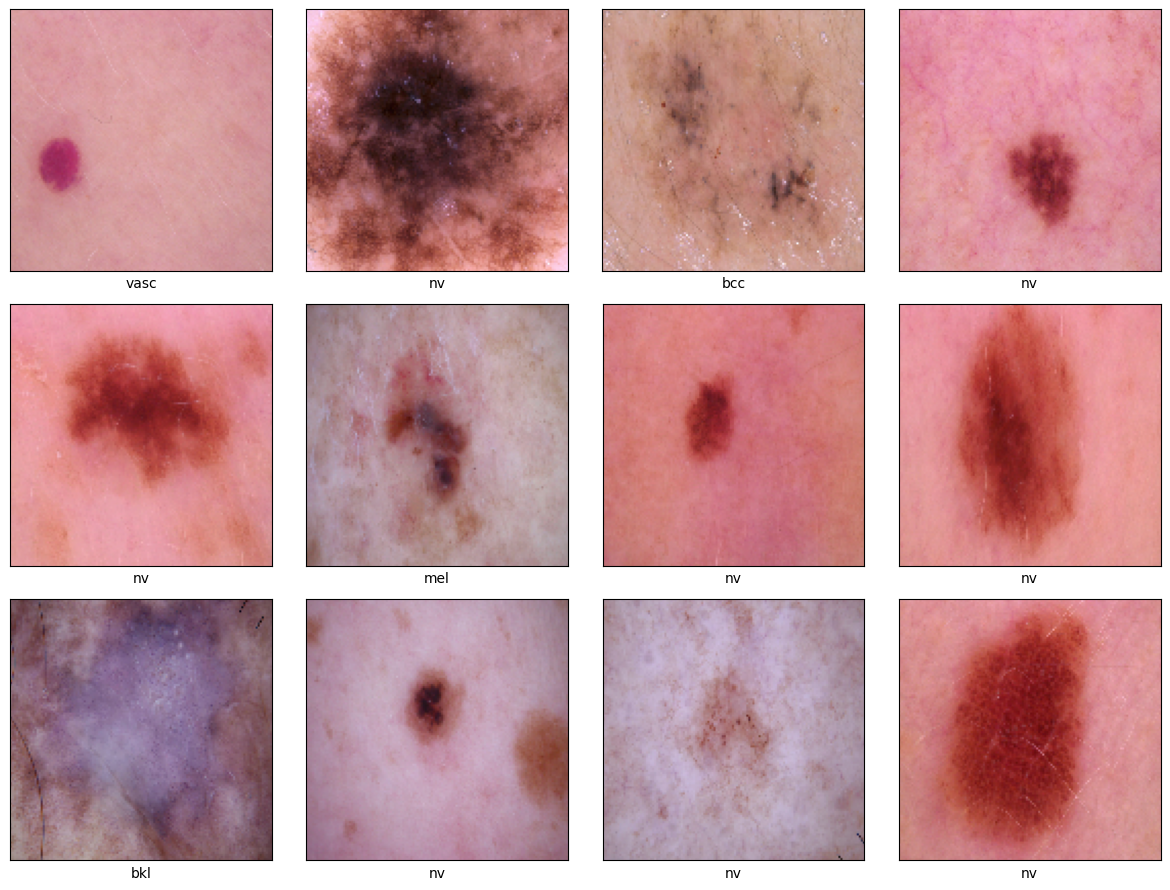

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import random

# Access class names from the TensorFlow dataset
class_names = train_tensorflow.class_names

# Take one batch from the TensorFlow dataset
for images, labels in train_tensorflow.take(1):
    images = images.numpy().astype(np.uint8)
    labels = labels.numpy()

# Sample 12 random images from this batch
indices = random.sample(range(images.shape[0]), 12)

fig, ax = plt.subplots(3, 4, figsize=(12, 9))
for i, axi in enumerate(ax.flat):
    axi.imshow(images[indices[i]])
    class_idx = np.argmax(labels[indices[i]])
    axi.set_xticks([])
    axi.set_yticks([])
    axi.set_xlabel(class_names[class_idx])
plt.tight_layout()
plt.show()


### Sci-Kit Learn

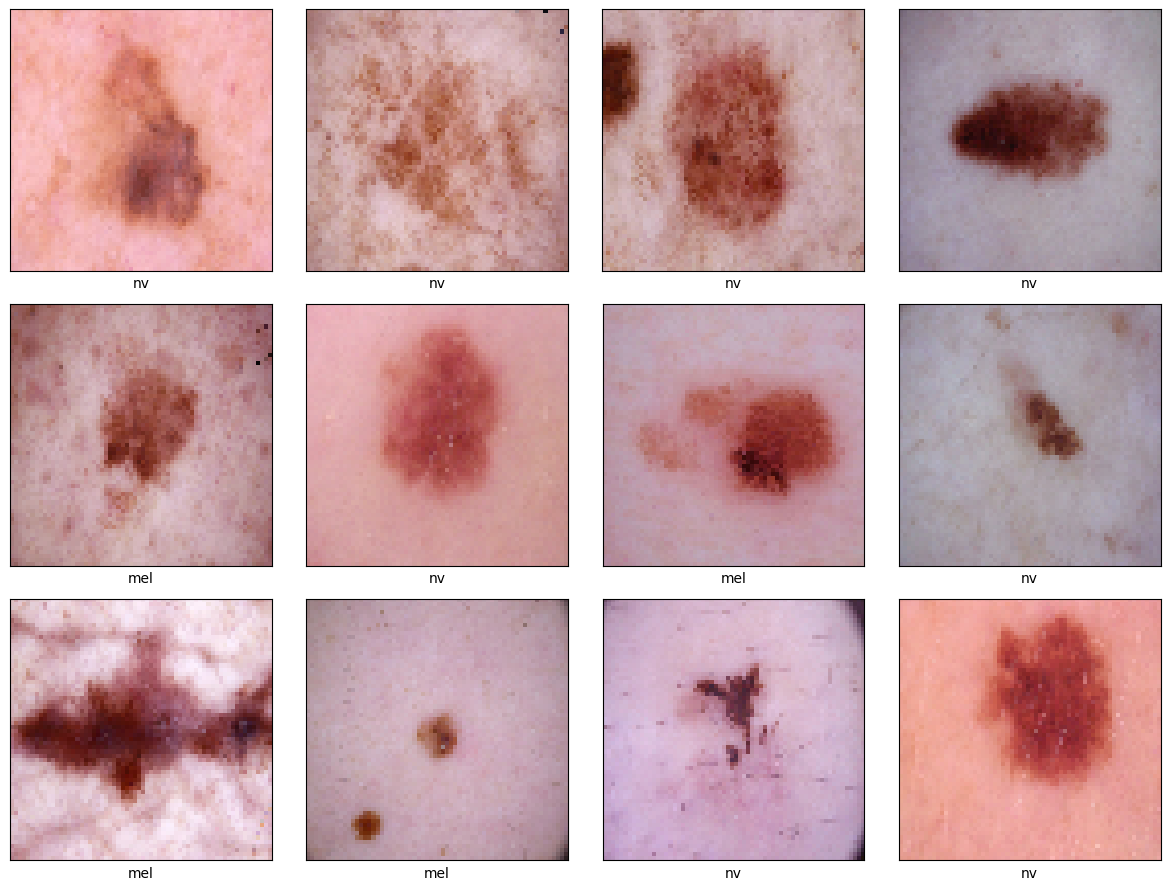

In [6]:
import matplotlib.pyplot as plt
import random

# Sample 12 random images from train set
indices = random.sample(range(X_train_sklearn_array.shape[0]), 12)

fig, ax = plt.subplots(3, 4, figsize=(12, 9))
for i, axi in enumerate(ax.flat):
    axi.imshow(X_train_sklearn_array[indices[i]].reshape(64, 64, 3).astype(np.uint8))
    axi.set_xticks([])
    axi.set_yticks([])
    axi.set_xlabel(y_train_sklearn_array[indices[i]])
plt.tight_layout()
plt.show()


# SVM using Scikit Learn

# CNN using Tensorflow

## Configuring the dataset from increased performance

This section of code is responsible for the application of the following two functions of the dataset. This is done to ensure that during the training process, when the datasets are fed into the model the I/O isn't blocked, this has the positive benefits of reducing system load and speeding up the training process exponentially.

The purpose of the `.cache()` function is to keep data loaded into the Tensorflow VM's memory after it's loaded of the disk. This is done in order to make the recall of the data far easier & faster. This is easily helpful during the evaluation process that occurs after each epoch. If the dataset is too large to fit into memory, then this method creates a performant on-disk cache, which is more efficient to read than many small files, this is akin to a swap partiation on linux, where addtional memory is storted tempoararly on the disk when memory is full.

The purpose of the `.prefetch()` function is to allow for the overlapping of data preprocessing and model execution while training. This inturn dramaticlly speeds up the training process.

Addtionally, the `.shuffle() `function randomly shuffles the data around in order to remove training bias since the data was previously ordered sequentially.

In [7]:
AUTOTUNE = tf.data.AUTOTUNE

train_tensorflow = train_tensorflow.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
test_tensorflow = test_tensorflow.cache().prefetch(buffer_size=AUTOTUNE)

## Standardizing the dataset

This section of code is responsible for scaling the RGB channel values for each pixel from `[0,255]` to `[0,1]`. This makes training the model easier since the matrix multiplication calucations returns far easier numbers to work with.

Dont run this more then once per instance

In [8]:
normalization_layer = tf.keras.layers.Rescaling(1./255)
normalized_ds = train_tensorflow.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))


2025-09-25 23:08:04.509367: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 130 of 1000
2025-09-25 23:08:14.522627: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 229 of 1000


0.0 0.76169103


2025-09-25 23:08:16.060324: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:483] Shuffle buffer filled.


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

num_classes = len(class_names)

# CNN model
model = models.Sequential([
    layers.InputLayer(input_shape=(img_height, img_width, 3)),
    layers.Rescaling(1./255),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes)   #
])


In [29]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)


In [30]:
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_6 (Rescaling)         │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 128, 128, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 64, 64, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 64, 64, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 128)            │     2,097,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,121,767 (8.09 MB)

 Trainable params: 2,121,767 (8.09 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
#DEBUGGING LAYERS - Ignore

for images, labels in train_tensorflow.take(1):
    print("Labels shape:", labels.shape)
    print("First 5 labels:", labels.numpy()[:5])

Labels shape: (32, 7)
First 5 labels: [[0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0.]]


2025-09-25 23:37:24.887250: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [31]:
epochs = 10
history = model.fit(
    train_tensorflow,
    validation_data=test_tensorflow,
    epochs=epochs
)


Epoch 1/10


251/251 ━━━━━━━━━━━━━━━━━━━━ 70s 273ms/step - accuracy: 0.6709 - loss: 0.9861 - val_accuracy: 0.6770 - val_loss: 0.9064
Epoch 2/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 113s 445ms/step - accuracy: 0.6871 - loss: 0.8719 - val_accuracy: 0.6885 - val_loss: 0.8468
Epoch 3/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 73s 292ms/step - accuracy: 0.7051 - loss: 0.8137 - val_accuracy: 0.7149 - val_loss: 0.7998
Epoch 4/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 66s 262ms/step - accuracy: 0.7209 - loss: 0.7577 - val_accuracy: 0.7039 - val_loss: 0.7913
Epoch 5/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 72s 287ms/step - accuracy: 0.7498 - loss: 0.6795 - val_accuracy: 0.7444 - val_loss: 0.7285
Epoch 6/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 64s 253ms/step - accuracy: 0.7710 - loss: 0.6172 - val_accuracy: 0.7419 - val_loss: 0.7230
Epoch 7/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 67s 269ms/step - accuracy: 0.7882 - loss: 0.5738 - val_accuracy: 0.7529 - val_loss: 0.7148
Epoch 8/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 56s 225ms/step - accuracy: 0.8040 - loss: 0.5189 - va

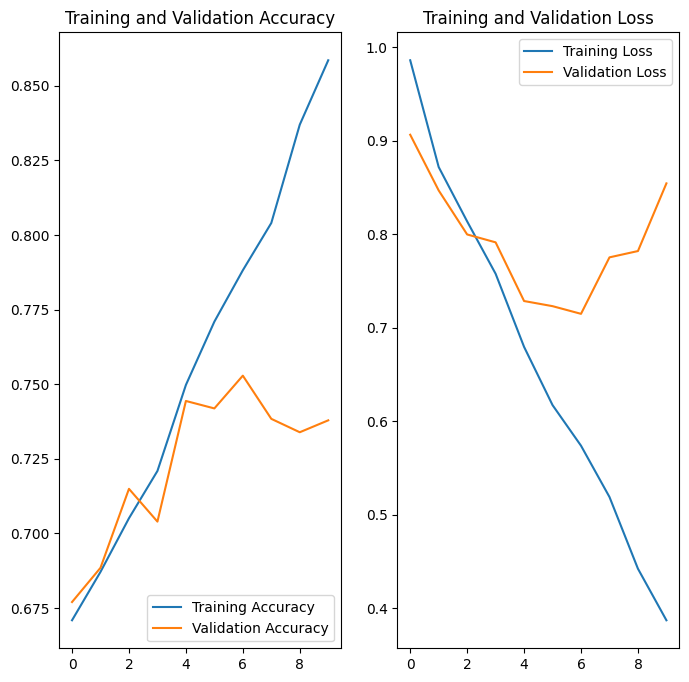

In [32]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [33]:
data_augmentation = tf.keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

/home/ruhanshafi/Projects/.venv/lib/python3.13/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


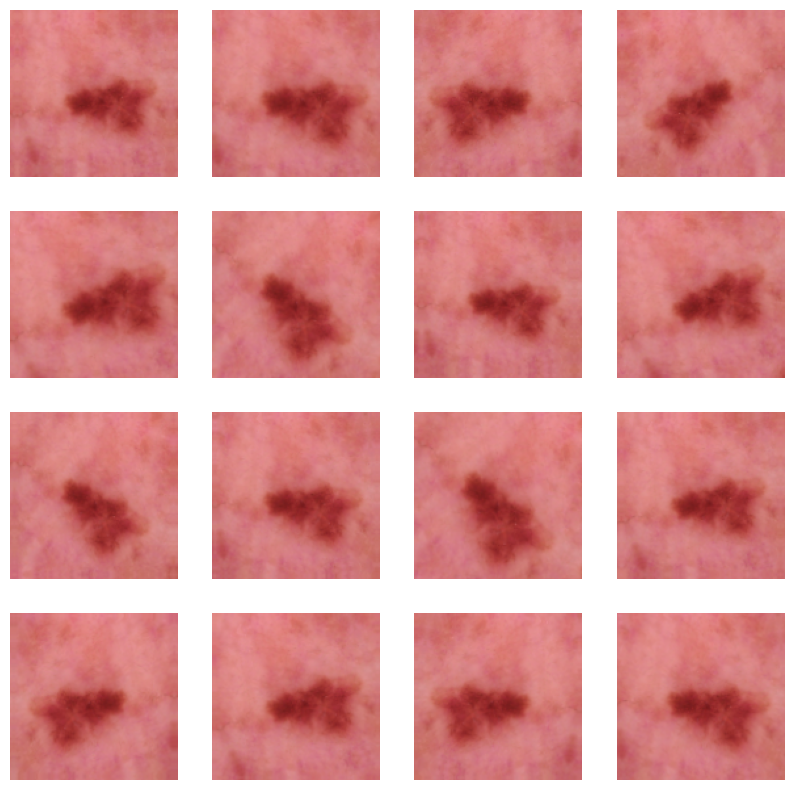

In [34]:


plt.figure(figsize=(10, 10))
for images, _ in train_tensorflow.take(1):
  for i in range(16):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")



In [38]:
model = models.Sequential([
    data_augmentation,
    layers.Rescaling(1./255),  # normalize after augmentation
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes)  # no softmax → use from_logits=True
])

In [39]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [40]:
model.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_5 (Sequential)       │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_10 (Rescaling)        │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_27 (Conv2D)              │ (None, 128, 128, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_27 (MaxPooling2D) │ (None, 64, 64, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_28 (Conv2D)              │ (None, 64, 64, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_28 (MaxPooling2D) │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_29 (MaxPooling2D) │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_9 (Flatten)             │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 128)            │     2,097,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,121,767 (8.09 MB)

 Trainable params: 2,121,767 (8.09 MB)

 Non-trainable params: 0 (0.00 B)

In [41]:
epochs = 15
history = model.fit(
  train_tensorflow,
  validation_data=test_tensorflow,
  epochs=epochs
)

Epoch 1/15
251/251 ━━━━━━━━━━━━━━━━━━━━ 56s 215ms/step - accuracy: 0.6654 - loss: 0.9800 - val_accuracy: 0.6755 - val_loss: 0.9264
Epoch 2/15
251/251 ━━━━━━━━━━━━━━━━━━━━ 63s 252ms/step - accuracy: 0.6847 - loss: 0.8436 - val_accuracy: 0.7114 - val_loss: 0.8009
Epoch 3/15
251/251 ━━━━━━━━━━━━━━━━━━━━ 62s 246ms/step - accuracy: 0.7152 - loss: 0.7808 - val_accuracy: 0.7064 - val_loss: 0.7832
Epoch 4/15
251/251 ━━━━━━━━━━━━━━━━━━━━ 58s 232ms/step - accuracy: 0.7269 - loss: 0.7456 - val_accuracy: 0.7059 - val_loss: 0.7638
Epoch 5/15
251/251 ━━━━━━━━━━━━━━━━━━━━ 67s 266ms/step - accuracy: 0.7272 - loss: 0.7164 - val_accuracy: 0.7164 - val_loss: 0.7751
Epoch 6/15
251/251 ━━━━━━━━━━━━━━━━━━━━ 120s 477ms/step - accuracy: 0.7374 - loss: 0.7019 - val_accuracy: 0.7154 - val_loss: 0.7568
Epoch 7/15
251/251 ━━━━━━━━━━━━━━━━━━━━ 106s 422ms/step - accuracy: 0.7471 - loss: 0.6834 - val_accuracy: 0.7499 - val_loss: 0.6894
Epoch 8/15
251/251 ━━━━━━━━━━━━━━━━━━━━ 104s 415ms/step - accuracy: 0.7484 - loss

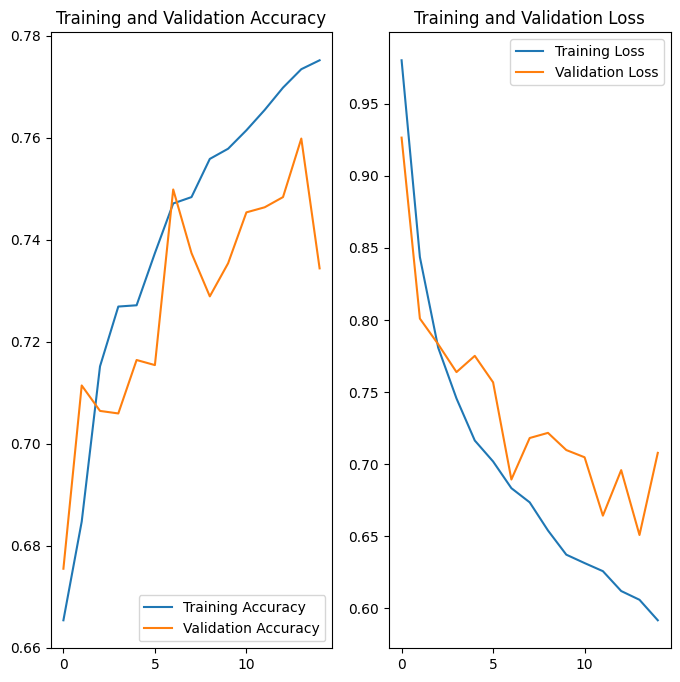

In [42]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


# Eval